<a href="https://colab.research.google.com/github/bforsbe/SK2534/blob/main/Phylo_znf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install necessary libraries and tools

### Subtask:
Install Biopython and a suitable MSA tool (e.g., Clustal Omega).


**Reasoning**:
Install biopython and clustal omega using pip and apt-get respectively.



In [1]:
%pip install biopython
!apt-get update -y
!apt-get install -y clustalw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 84.3 MB/s eta 0:00:00
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://cli.github.com/packages stable InRelease [3,917 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://cli.github.com/packages stable/main amd64 Packages [346 B]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://r2u.stat.i

In [2]:
#@title Load fasta from URL and save as template
import requests
import io
from Bio import SeqIO

# Define the URL of the FASTA file and the local filename
url = "https://raw.githubusercontent.com/bforsbe/SK2534/main/aligned_output.fasta"
local_fasta_file = "template_aligned.fasta"

# Download the content of the file and save it locally if it doesn't exist
try:
    with open(local_fasta_file, "r") as f:
        print(f"Using existing template file: {local_fasta_file}")
except FileNotFoundError:
    print(f"Downloading template file from: {url}")
    response = requests.get(url)
    response.raise_for_status() # Raise an exception for bad status codes
    with open(local_fasta_file, "w") as f:
        f.write(response.text)
    print(f"Template file downloaded and saved as: {local_fasta_file}")

# Read the sequences from the local FASTA file using SeqIO.parse
sequences = list(SeqIO.parse(local_fasta_file, "fasta"))

# Print the number of sequences loaded to verify
print(f"Number of sequences loaded from template: {len(sequences)}")

Template file downloaded and saved as: template_aligned.fasta
Number of sequences loaded from template: 3021


## Add query sequence
Define a query sequence and its original sequence, and them to the list of sequences.

The query here is a mutated version of the original, so that we may compare the mutations to those that occur naturally.


In [3]:
#@title Add original and query sequence
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# Define the original and query sequence strings
original_sequence_string = "YKCGLCERSFVEKSALSRHQRVHKN" #@param {type:"string"}
query_sequence_string = "LMCHHCPQEFESERRLKIHGQIHMN" #@param {type:"string"}

# Create SeqRecord objects for the original and query sequences with fixed IDs
original_sequence = SeqRecord(Seq(original_sequence_string), id="Original_Sequence", description="")
query_sequence = SeqRecord(Seq(query_sequence_string), id="Query_Sequence", description="")

# Create a new list of sequences including the original sequences from the template, the original, and the query
sequences_with_original_and_query = sequences + [original_sequence, query_sequence]

# Print the updated number of sequences to verify
print(f"Updated number of sequences (including original and query): {len(sequences_with_original_and_query)}")

Updated number of sequences (including original and query): 3023


## Prepare sequences for alignment

Modify sequence IDs to be unique and write all sequences (including the query) to a temporary FASTA file.


In [4]:
#@title Prepare sequences for alignment
# Modify sequence IDs to be unique and clear descriptions for the list including the query and original
for i, seq in enumerate(sequences_with_original_and_query):
    # Only modify IDs if they are not the original or query sequences
    if seq.id != "Original_Sequence" and seq.id != "Query_Sequence":
        seq.id = f"{seq.id}_{i}"
    seq.description = "" # Clear description to avoid issues with some tools

# Define a filename for the temporary FASTA file
temp_in_file = "temp_sequences_for_alignment.fasta"

# Write the modified sequences to the temporary FASTA file
SeqIO.write(sequences_with_original_and_query, temp_in_file, "fasta")

# Print confirmation message
print(f"Prepared sequences (including original and query) and saved to {temp_in_file}")

Prepared sequences (including original and query) and saved to temp_sequences_for_alignment.fasta


## Perform multiple sequence alignment

### Subtask:
Use ClustalW to align the sequences from the temporary file and save the output to a new file.

Use Biopython's ClustalwCommandline to perform multiple sequence alignment on the sequences in the temporary FASTA file and save the output to a new FASTA file.


In [5]:
#@title Make MSA
from Bio import AlignIO
from Bio import Align
from Bio.Align.Applications import ClustalwCommandline

# Define the name for the output alignment file
out_file_aln = "aligned_with_query.aln"
out_file_fasta = "aligned_with_query.fasta"

# Create a ClustalwCommandline object
# Specify the path to the clustalw executable if it's not in your PATH
clustalw_cline = ClustalwCommandline("clustalw", infile=temp_in_file, outfile=out_file_aln)

# Run the command line tool
stdout, stderr = clustalw_cline()

# Print confirmation message
print(f"Multiple sequence alignment performed and saved to {out_file_aln}")

# Convert aln -> fasta using AlignIO (still needed for writing)
alignment_aln = AlignIO.read(out_file_aln, "clustal")
AlignIO.write(alignment_aln, out_file_fasta, "fasta")

/usr/local/lib/python3.12/dist-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


Multiple sequence alignment performed and saved to aligned_with_query.aln


1

## Read the alignment
Read the aligned sequences from the output file using `AlignIO.read` (using AlignIO.read with the 'fasta' format and print the alignment object.)


In [8]:
#@title Read alignment file
from Bio import AlignIO

# Define the name of the alignment file output by ClustalW
alignment_file = out_file_aln

# Read the alignment file using AlignIO.read with 'clustal' format
try:
    alignment = AlignIO.read(alignment_file, "clustal")

    # Print the alignment object to verify
    print("Alignment object:")
    print(alignment)

except FileNotFoundError:
    print(f"Error: The file {alignment_file} was not found.")
except Exception as e:
    print(f"An error occurred while reading the file: {e}")

Alignment object:
Alignment with 3023 rows and 50 columns
----YHCI---ICGRDFN----RKH-----HLKIHQR-IHT--------- AF-F1R7V0-F1-model_v4_110_262
----YHCG---LCGRGFN----RKH-----HLKIHQR-IHT--------- AF-A0A5A9P679-F1-model_v4_1322
----YRCQ---VCGRGFI----RKQ-----TLSDHMR-IHT--------- AF-A0A6P7WQY9-F1-model_v4_1130
----YPCE---VCGRGFY----RKD-----KLSRHRR-IHLN-------- AF-A0A3S3PGB1-F1-model_v4_1742
----YRCQ---LCGRGFL----RHS-----DLSTHLR-FHN--------- AF-A0A6P5AMY4-F1-model_v4_1762
----YQCD---ICGQKFV----QKI-----NLTHHAR-IHS--------- AF-P15619-F1-model_v4_429_267
----YQCD---ICGQKFV----QKI-----NLTHHAR-IHS--------- AF-P15619-F1-model_v4_924_268
----YRCN---ICGAQFN----RPA-----NLKTHTR-IHS--------- LevyLab_P41182_V1_5_relaxed_A_
----YRCN---ICGAQFN----RPA-----NLKTHTR-IHSG-------- 2lceA02_2699_270
----YTCD---ICGRSFS----RTN-----TLVTHRR-IHS--------- AF-T1EK57-F1-model_v4_1669_271
----YTCD---ICGRSFK----RKS-----YLVEHNR-THTD-------- AF-A0A6G0WU34-F1-model_v4_1876
----HRCQ---ECGRSFR----RPK-----ELATHQR-LHS--------- AF-A0A

## Analyze sequence identity

### Subtask:
Calculate the maximum sequence identity of the query sequence against all other sequences in the alignment.


**Reasoning**:
Calculate the maximum sequence identity by iterating through the alignment, comparing the query sequence to every other sequence, and keeping track of the highest identity score found.



In [9]:
#@title Analyze sequence identity and display best match alignment
# Find the query and original sequences in the alignment using their fixed IDs
query_sequence_id = "Query_Sequence"
original_sequence_id = "Original_Sequence"
query_seq = None
original_seq = None

for record in alignment:
    if record.id == query_sequence_id:
        query_seq = record
    elif record.id == original_sequence_id:
        original_seq = record

if query_seq is None:
    print(f"Error: Query sequence with ID '{query_sequence_id}' not found in the alignment.")
else:
    max_identity = 0.0
    best_match_id = None
    best_match_seq = None

    # Iterate through each sequence in the alignment
    for record in alignment:
        # Skip the query and original sequences themselves when finding best match
        if record.id == query_sequence_id or record.id == original_sequence_id:
            continue

        # Calculate sequence identity
        identical_residues = 0
        aligned_length = 0
        for i in range(alignment.get_alignment_length()):
            query_residue = query_seq[i]
            current_residue = record[i]

            # Only consider positions where neither sequence has a gap
            if query_residue != '-' and current_residue != '-':
                aligned_length += 1
                if query_residue == current_residue:
                    identical_residues += 1

        # Avoid division by zero if there are no aligned positions
        if aligned_length > 0:
            identity = (identical_residues / aligned_length) * 100
            if identity > max_identity:
                max_identity = identity
                best_match_id = record.id
                best_match_seq = record
        else:
            identity = 0.0 # Or handle as appropriate if no comparable positions

    print(f"Maximum sequence identity of the query sequence against others (excluding original): {max_identity:.2f}%")
    if best_match_id:
        print(f"Sequence with the highest identity: {best_match_id}")

        # Display the alignment of the query, original, and the best match
        print("\nAlignment of Query Sequence, Original Sequence, and Best Match:")
        # Determine the maximum length of the sequence IDs for alignment
        max_id_length = max(len(query_seq.id), len(original_seq.id) if original_seq else 0, len(best_match_id))
        if original_seq:
             print(f"{original_seq.seq} {original_seq.id.ljust(max_id_length)}")
        print(f"{query_seq.seq} {query_seq.id.ljust(max_id_length)}")
        print(f"{best_match_seq.seq} {best_match_id.ljust(max_id_length)}")

Maximum sequence identity of the query sequence against others (excluding original): 44.00%
Sequence with the highest identity: AF-A0A553NCF9-F1-model_v4_1939

Alignment of Query Sequence, Original Sequence, and Best Match:
----YKCGL---CERSFV----EKS-----ALSRHQR-VHKN-------- Original_Sequence             
----LMCHH---CPQEFE----SER-----RLKIHGQ-IHMN-------- Query_Sequence                
----YRCPH---CPKEFV----QKS-----NLNRHIR-IHLN-------- AF-A0A553NCF9-F1-model_v4_1939


## Analyze conservation

### Subtask:
Analyze the conservation of residues in the query sequence compared to the original sequence, and compare this to the overall conservation at those positions in the multiple sequence alignment.

**Reasoning**:
Calculate the conservation score for each position in the overall alignment. Then, for each position in the query sequence, compare the residue to the corresponding residue in the original sequence and the conservation score at that position in the overall alignment. Print the results to show where the query mutation aligns with highly conserved or variable positions.

In [10]:
#@title Analyze conservation of query sequence mutations
# Function to calculate conservation at a given column in the alignment
def calculate_conservation(column):
    """Calculates the conservation score for a column in a multiple sequence alignment."""
    # Count the occurrences of each residue (excluding gaps)
    residue_counts = {}
    total_residues = 0
    for residue in column:
        if residue != '-':
            total_residues += 1
            residue_counts[residue] = residue_counts.get(residue, 0) + 1

    # Calculate the conservation score (simple frequency of the most common residue)
    if total_residues == 0:
        return 0.0
    max_count = max(residue_counts.values()) if residue_counts else 0
    conservation = (max_count / total_residues) * 100
    return conservation

# Find the query and original sequences in the alignment
query_sequence_id = "Query_Sequence"
original_sequence_id = "Original_Sequence"
query_seq = None
original_seq = None

for record in alignment:
    if record.id == query_sequence_id:
        query_seq = record
    elif record.id == original_sequence_id:
        original_seq = record

if query_seq is None or original_seq is None:
    print("Error: Query or Original sequence not found in the alignment.")
else:
    print("Conservation Analysis:")
    print("-" * 60)
    print(f"{'Position':<10} {'Original':<10} {'Query':<10} {'Overall Conservation (%)':<25} {'Observation':<15}")
    print("-" * 60)

    # Iterate through the alignment positions
    for i in range(alignment.get_alignment_length()):
        original_residue = original_seq[i]
        query_residue = query_seq[i]

        # Skip if both original and query have gaps
        if original_residue == '-' and query_residue == '-':
            continue

        # Calculate conservation at this position in the overall alignment
        column = alignment[:, i]
        overall_conservation = calculate_conservation(column)

        observation = ""
        if original_residue != '-' and query_residue != '-':
            if original_residue != query_residue:
                observation = "Mutation"
                if overall_conservation > 70: # Example threshold for high conservation
                    observation += " (Highly Conserved)"
                elif overall_conservation < 30: # Example threshold for low conservation
                    observation += " (Variable)"
            else:
                 observation = "No Mutation"


        print(f"{i:<10} {original_residue:<10} {query_residue:<10} {overall_conservation:<25.2f} {observation:<15}")

    print("-" * 60)

Conservation Analysis:
------------------------------------------------------------
Position   Original   Query      Overall Conservation (%)  Observation    
------------------------------------------------------------
4          Y          L          70.64                     Mutation (Highly Conserved)
5          K          M          35.09                     Mutation       
6          C          C          99.07                     No Mutation    
7          G          H          13.65                     Mutation (Variable)
8          L          H          37.17                     Mutation       
12         C          C          99.87                     No Mutation    
13         E          P          52.56                     Mutation       
14         R          Q          69.63                     Mutation       
15         S          E          31.96                     Mutation       
16         F          F          91.46                     No Mutation    
17         V  

## Analyze Sequence Identity Distribution

### Subtask:
Calculate sequence identity against original and query sequences and visualize the distribution and relationship.

**Reasoning**:
Calculate the sequence identity of each sequence in the alignment against the original and query sequences. Store these identities and then use matplotlib and seaborn to create a histogram of identities against the original and a scatterplot of identities against the original versus identities against the query.

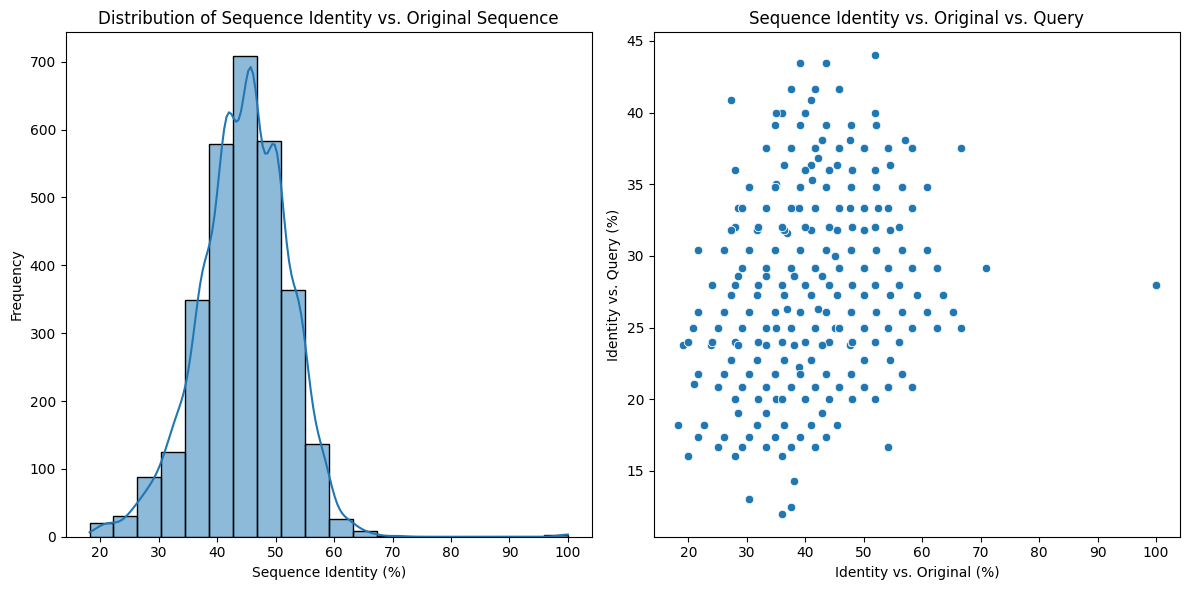

In [11]:
#@title Analyze and visualize sequence identity distribution
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Find the query and original sequences in the alignment
query_sequence_id = "Query_Sequence"
original_sequence_id = "Original_Sequence"
query_seq = None
original_seq = None

for record in alignment:
    if record.id == query_sequence_id:
        query_seq = record
    elif record.id == original_sequence_id:
        original_seq = record

if query_seq is None or original_seq is None:
    print("Error: Query or Original sequence not found in the alignment.")
else:
    identity_data = []
    # Iterate through each sequence in the alignment
    for record in alignment:
        # Skip the query and original sequences themselves
        if record.id == query_sequence_id or record.id == original_sequence_id:
            continue

        # Calculate sequence identity against original sequence
        identical_residues_original = 0
        aligned_length_original = 0
        for i in range(alignment.get_alignment_length()):
            original_residue = original_seq[i]
            current_residue = record[i]

            if original_residue != '-' and current_residue != '-':
                aligned_length_original += 1
                if original_residue == current_residue:
                    identical_residues_original += 1

        identity_original = (identical_residues_original / aligned_length_original) * 100 if aligned_length_original > 0 else 0.0

        # Calculate sequence identity against query sequence
        identical_residues_query = 0
        aligned_length_query = 0
        for i in range(alignment.get_alignment_length()):
            query_residue = query_seq[i]
            current_residue = record[i]

            if query_residue != '-' and current_residue != '-':
                aligned_length_query += 1
                if query_residue == current_residue:
                    identical_residues_query += 1

        identity_query = (identical_residues_query / aligned_length_query) * 100 if aligned_length_query > 0 else 0.0

        identity_data.append({'ID': record.id, 'Identity_vs_Original': identity_original, 'Identity_vs_Query': identity_query})

    # Create a pandas DataFrame
    identity_df = pd.DataFrame(identity_data)

    # Plotting
    plt.figure(figsize=(12, 6))

    # Histogram of identity against original
    plt.subplot(1, 2, 1)
    sns.histplot(identity_df['Identity_vs_Original'], bins=20, kde=True)
    plt.title('Distribution of Sequence Identity vs. Original Sequence')
    plt.xlabel('Sequence Identity (%)')
    plt.ylabel('Frequency')

    # Scatterplot of identity vs original vs identity vs query
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=identity_df, x='Identity_vs_Original', y='Identity_vs_Query')
    plt.title('Sequence Identity vs. Original vs. Query')
    plt.xlabel('Identity vs. Original (%)')
    plt.ylabel('Identity vs. Query (%)')

    plt.tight_layout()
    plt.show()

In [13]:
!pip install logomaker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 90.5 MB/s eta 0:00:00


Number of sequences: 3023
Alignment length: 50
Consensus: YACPYKCSEP-QCGKSFSSD-EQSSSRILSSLTRHQRRIHTGNNNHKD--
Degenerate consensus: [FY][AQ][CDY][IPT][ACEFHIKLMNPQRSVWY][ACDEFGHIKLMNPQRSTVWY][CEFGHLNSWY][ACDEFGHIKLMNPQRSTVWY][ACDEFGHIKLMNPQRSTVWY][EKP]-[ACDEFGHIKLMNPQRSTVY][CRSV][ACDEFGHIKLMNPQRSTVWY][ACDEFGHIKLMNQRSTVWY][ACDEFGHIKLMNPQRSTVWY][ACFGHILPRSTVWY][ACDEFGHIKLMNPQRSTVWY][DHNPST]D-[DEGHIKLNQSTVY][ACDEFGHIKLMNPQRSTVWY][ACDEFGHIKLMNPQRSTVWY][ACDEFGHIKLMNPQRSTVWY][AFHKRSTY]RIL[ACGHKNQSTW][ACDEFGHIKLMNPQRSTVWY][ACFHIKLMQRTVWY][ACDEFGHIKLMNPQRSTVWY][ACDEFGHIKLMNPQRSTVWY][DEFHLQY][ACDEFGHIKLMNQRSTVWY][ACDEFGHIKLMNPQRSTVWY][AFHKRT][ACDEFGHIKLMNQRSTVY][ACDEFGHIKLMNPQRSTVWY][ACDEFGHIKLMNQRSTVY][ACDEFGHIKLMNPQRSTVWY][ADEGHIKMNQRSTV][ADEGKNPRT][ALMN][EHQ][KS][DG]--
Query Sequence: ----LMCHH---CPQEFE----SER-----RLKIHGQ-IHMN--------


<Figure size 1500x400 with 0 Axes>

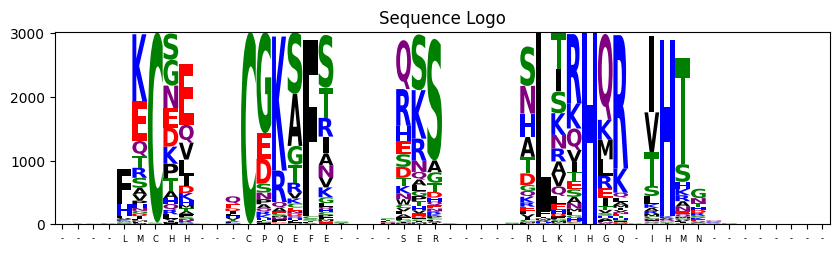

In [14]:
#@title Create sequence logo
from Bio import AlignIO
from collections import Counter
import pandas as pd
import logomaker
import matplotlib.pyplot as plt

# Read the alignment (FASTA or ALN)
alignment = AlignIO.read("aligned_with_query.aln", "clustal")

num_seqs = len(alignment)
alignment_length = alignment.get_alignment_length()
print("Number of sequences:", num_seqs)
print("Alignment length:", alignment_length)

# Build consensus sequence (preserving all columns)
consensus = ""
degenerate_consensus = ""
counts_matrix = []  # for logo

for col_idx in range(alignment_length):
    column = alignment[:, col_idx]             # get column as string
    counts = Counter(res for res in column if res != "-")  # ignore gaps
    counts_matrix.append({aa: counts.get(aa, 0) for aa in "ACDEFGHIKLMNPQRSTVW"})

    if counts:
        # Majority vote for consensus
        consensus += counts.most_common(1)[0][0]
        # Degenerate: include all residues that appear in column
        residues = sorted(counts.keys())
        degenerate_consensus += "[" + "".join(residues) + "]" if len(residues) > 1 else residues[0]
    else:
        # Column is all gaps
        consensus += "-"
        degenerate_consensus += "-"

print("Consensus:", consensus)
print("Degenerate consensus:", degenerate_consensus)

# Create a DataFrame for sequence logo
df = pd.DataFrame(counts_matrix)
df.index.name = "Position"

# Plot logo
plt.figure(figsize=(15,4))
logo = logomaker.Logo(df, color_scheme='chemistry')
plt.title("Sequence Logo")

ticks=True
if ticks:
    # 6. Add Query_Sequence as tick labels
    query_sequence = None
    # Access records using the .sequences attribute for modern Bio.Align objects
    # Now reload using AlignIO (old API keeps dashes)
    msa = AlignIO.read("aligned_with_query.fasta", "fasta")

    # Extract the gappy sequence
    query_sequence = str([rec.seq for rec in msa if rec.id == "Query_Sequence"][0])
    for record in msa:
        if record.id == "Query_Sequence":
            query_sequence = str(record.seq)
            break
    print("Query Sequence:", query_sequence)

    if query_sequence:
        # Set tick positions to correspond to the positions in the sequence
        tick_positions = range(len(query_sequence))
        # Set tick labels to the characters of the query sequence
        plt.gca().set_xticks(tick_positions)
        plt.gca().set_xticklabels(list(query_sequence))
        # Optional: Rotate labels if they overlap
        plt.xticks(rotation=0)
        plt.tick_params(axis='x', which='major', labelsize=6) # Adjust label size if needed

plt.show()


In [12]:
# @title Calculate pairwise sequence identities
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO

# Define the name of the FASTA file
aln_file = "aligned_with_query.aln"
fasta_file = "aligned_with_query.fasta"

# Read the Clustal alignment
alignment = AlignIO.read(aln_file, "clustal")

# Write to FASTA
AlignIO.write(alignment, fasta_file, "fasta")

# Read the sequences from the FASTA file
try:
    sequences = list(SeqIO.parse(fasta_file, "fasta"))
    print(f"Number of sequences loaded: {len(sequences)}")
except FileNotFoundError:
    print(f"Error: The file {fasta_file} was not found.")
    sequences = [] # Initialize as empty to avoid errors later

# Initialize a list to store pairwise identities
pairwise_identities = []

# Iterate through all unique pairs of sequences
for i in range(len(sequences)):
    for j in range(i + 1, len(sequences)): # Start from i+1 to avoid self-comparison and duplicate pairs
        seq1 = sequences[i]
        seq2 = sequences[j]

        identical_residues = 0
        aligned_length = 0

        # Iterate through the residues at each position
        # Assuming sequences are already aligned
        min_len = min(len(seq1.seq), len(seq2.seq)) # Use min length in case of slight variations (though aligned should be same)
        for k in range(min_len):
            res1 = seq1.seq[k]
            res2 = seq2.seq[k]

            # Consider positions where neither sequence has a gap
            if res1 != '-' and res2 != '-':
                aligned_length += 1
                if res1 == res2:
                    identical_residues += 1

        # Calculate sequence identity
        identity = (identical_residues / aligned_length) * 100 if aligned_length > 0 else 0.0

        # Append the identity to the list
        pairwise_identities.append(identity)

print(f"Calculated {len(pairwise_identities)} pairwise identities.")

# Create a histogram of the pairwise_identities list
plt.figure(figsize=(10, 6))
sns.histplot(pairwise_identities, bins=30, kde=True)

# Add title and labels
plt.title('Distribution of Pairwise Sequence Identities')
plt.xlabel('Sequence Identity (%)')
plt.ylabel('Frequency')

# Display the plot
plt.show()

Number of sequences loaded: 3023


KeyboardInterrupt: 